In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Models
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Over
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.stats import norm
from scipy import stats

import missingno as msno
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# To draw a tree
from graphviz  import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 40% !important; height: 50% !important;} </style>"
HTML( style )
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\graphviz2.38\\bin" + os.pathsep + "C:\\Program Files (x86)\\graphviz2.38"

In [ ]:
df = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')

In [ ]:
pd.options.display.max_columns = df.shape[1] # let's show all columns
df.head()

features:
* id:ID
* battery_power:Total energy a battery can store in one time measured in mAh
* blue:Has bluetooth or not
* clock_speed:speed at which microprocessor executes instructions
* dual_sim:Has dual sim support or not
* fc:Front Camera mega pixels
* four_g:Has 4G or not
* int_memory:Internal Memory in Gigabytes
* m_dep:Mobile Depth in cm
* mobile_wt:Weight of mobile phone
* n_cores:Number of cores of processor
* pc:Primary Camera mega pixels
* px_height:Pixel Resolution Height
* px_width:Pixel Resolution Width
* ram:Random Access Memory in Megabytes
* sc_h:Screen Height of mobile in cm
* sc_w:Screen Width of mobile in cm
* talk_time:longest time that a single battery charge will last when you are
* three_g:Has 3G or not
* touch_screen:Has touch screen or not
* wifi:Has wifi or not

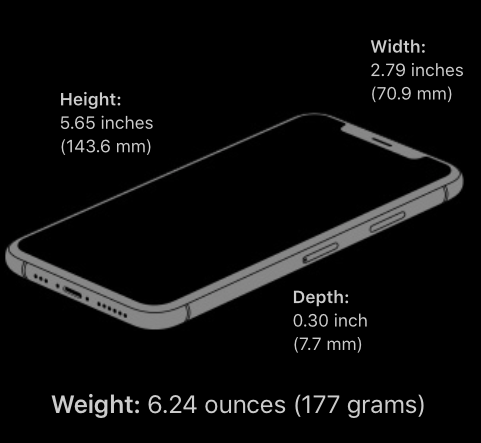

Let's pay our attention to the missing values 

In [ ]:
msno.matrix(df)

It look like we were lucky. Make shure of that.

In [ ]:
df.isnull().sum()

Great. 
Let's see if there are any anomole values.

In [ ]:
df.describe()

At first glance, values that clearly not true are not visible.

Rate target variable.

In [ ]:
y = df['price_range']

In [ ]:
sns.distplot(y, kde=False)

Good, sample is perfectly balanced.
See on features.

In [ ]:
df.info()

We haven't string features. So, we are going to find categorical features.

In [ ]:
for i, j in enumerate(list(df)):
    print(j, len(df[j].unique()))

although the screen height has only 15 unique values, it is hardly a categorical variable, I think that it is related to the size of the sample. Therefore, we take as a limitation the value of 8

In [ ]:
def categorical(df, a):
    cat_col = []
    for i in df.columns:
        if len(df[i].unique()) <= a:
            cat_col.append(i)
    return(cat_col)

In [ ]:
cat_columns = categorical(df, 8)

In [ ]:
df[cat_columns].hist(figsize=(15,10), bins=50)

Categorical features are mostly balanced, except is the presence of 3G. Most models have 3g.

Find out if is there any correlation between these features.

In [ ]:
sns.heatmap(data=df[cat_columns].corr(), cbar=True, annot=True, square=True, annot_kws={'size': 10},)

It is worth taking a closer look at the availability of 3g and 4g.

In [ ]:
df[df['three_g'] == 0]['four_g'].hist()

So, if the phone does not have 3G, then it does not have 4G. But in some models there is 3G, while 4G is not.

In [ ]:
num_columns = [x for x in df.columns if x not in cat_columns]
for i in num_columns:
    sns.distplot(df[i])
    plt.show()

Yeah! There are anomalies. When analyzing the graphs, we noticed that the variable sc_w (screen width in pixels) has zero values, which is strange. Like px_height.

Maybe the sc_w and px_widht correlate?

In [ ]:
df_size = df[['sc_w', 'px_width', 'sc_h', 'px_height']]
df_size_not_zero = df_size.drop(df_size[(df_size['sc_w'] == 0) | (df_size['px_height'] == 0)].index)
df_size_not_zero.corr()
sns.heatmap(data=df_size_not_zero.corr(), yticklabels=['sc_w           ', 'px_width      ', 'sc_h             ', 'px_height      '],
           cbar=True, annot=True, square=True)

There is no explicit relationship between px_width and sc_w (

Maybe you should try to multiply the px_height and px_width

In [ ]:
df_size_not_zero['area_sc'] = df_size_not_zero['sc_w'] * df_size_not_zero['sc_h']
df_size_not_zero['area_px'] = df_size_not_zero['px_width'] * df_size_not_zero['px_height']
sns.heatmap(data=df_size_not_zero.corr(), cbar=True, annot=True, square=True, annot_kws={'size': 10},)

Well, it looks like the screen resolution is clearly not related to its physical size. But in all the graphs, sc_w correlates with sc_h. Let's see our joint plot.

In [ ]:
sns.jointplot(x='sc_w' , y='sc_h' , data=df_size_not_zero)

This plot indicates that all phones have a higher resolution in height and a lower resolution in width

In this case, the optimal solution would be to replace zeros with the median value.

In [ ]:
df['sc_w'] = df[~df.apply(lambda x: x.eq(0))]['sc_w']
df['px_height'] = df[~df.apply(lambda x: x.eq(0))]['px_height']
df['sc_w'] = df.groupby('sc_h')['sc_w'].transform(lambda x: x.fillna(x.median()))
df['px_height'] = df.groupby('px_width')['px_height'].transform(lambda x: x.fillna(x.median()))

Well, we have prepared our features. Take a closer look at each of them. Maybe we'll see something interesting.

In [ ]:
fig = plt.figure(figsize=(15,12))
r = sns.heatmap(df.corr(), cmap='Purples')
r.set_title("Correlation ")

In [ ]:
num_top10_corr = df.corr()['price_range'].sort_values(ascending=False).head(10).to_frame()
cm = sns.light_palette("blue", as_cmap=True)
s = num_top10_corr.style.background_gradient(cmap=cm)
s

The price of a phone is most closely related to its RAM.

In [ ]:
sns.boxplot(x='price_range', y='ram', data=df)

It is expected that the larger the ram, the higher the cost of the phone.

In [ ]:
plt.figure(figsize=(10,6))
df['fc'].hist(alpha=0.5, color='blue', label='Front camera')
df['pc'].hist(alpha=0.5, color='red', label='Primary camera')
plt.legend()
plt.xlabel('MegaPixels')

Most phones have a main camera. At the same time, about 700 models (35% of the sample) do not have a front camera.

In [ ]:
g = sns.FacetGrid(df, col="dual_sim", hue="price_range", palette="Set1", height=5)
g = g.map(sns.distplot, "ram").add_legend()

In [ ]:
g = sns.FacetGrid(df, col="touch_screen", hue="price_range", palette="Set1", height=5)
g = g.map(sns.distplot, "ram").add_legend()

In [ ]:
g = sns.FacetGrid(df, col="wifi", hue="price_range", palette="Set1", height=5)
g = g.map(sns.distplot, "ram").add_legend()

In [ ]:
g = sns.FacetGrid(df, col="blue", hue="price_range", palette="Set1", height=5)
g = g.map(sns.distplot, "ram").add_legend()

Distribution for binary traits are quite similar.

# Create train and test sets

Create a stratified test sample. And we can use accuracy as a metric.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["price_range"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

In [ ]:
df_train["price_range"].hist(figsize=(10,5), bins=10)
print('Размер train выборки', df_train.size)

In [ ]:
df_test["price_range"].hist(figsize=(10,5), bins=10)
print('Размер test выборки', df_test.size)

In [ ]:
y_train = df_train['price_range']
X_train = df_train.drop('price_range', axis=1)
y_test = df_test['price_range']
X_test = df_test.drop('price_range', axis=1)

Fine. Let's start with a model for which you do not need to transform attributes. Decision tree. Just see at what height it starts overfitting.

In [ ]:
max_depth_values = range(1,100)
scores_data = pd.DataFrame()
best_depth = 0
best_score = 0
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    if test_score > best_score:
        best_score = test_score
        best_depth = max_depth
    temp_score_data = pd.DataFrame({'max_deph': [max_depth],
                                   'train_score': [train_score],
                                   'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [ ]:
scores_data_long = pd.melt(scores_data,
                           id_vars=['max_deph'], 
                           value_vars=['train_score','test_score'],
                           var_name=['set_type'], 
                           value_name='score')

In [ ]:
sns.lineplot(x='max_deph', y='score', hue='set_type', data=scores_data_long)

Overfitting comes after 6 leaves in depth.

In [ ]:
print(best_score, best_depth)

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth)
clf.fit(X_train, y_train)

Draw our tree and see which features are more important.

In [ ]:
graph = Source(tree.export_graphviz(clf,
                                    out_file=None,
                                    feature_names=list(X_train),
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

Next, we will check the score for cross-validation.

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
for k in range(1, 102, 10):
    clf = RandomForestRegressor(n_estimators=k)
    acc = cross_val_score(clf, X_train, y_train, cv=kf)
    acc_mean = np.mean(acc)
    print(acc_mean, k)

Although the forest of trees is almost not overfiting, we see that 50 trees will be enough for him. A further increase in this hyperparameter does not lead to an increase in accuracy.

In [ ]:
clf = RandomForestRegressor(n_estimators=50)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

Unexpectedly, on a test sample, the result was better than on validation. Maybe we were lucky, but maybe due to the fact that we had 0.8 data on cross validation, and now that's it. For a dataset of our size, this can be significant.

Check what gives KNN, with a different number of neighbors.

In [ ]:
n_list = []
score_list_knn = []
for n in range(1, 20):
    clf = KNeighborsClassifier(n_neighbors=n)
    aсс = cross_val_score(clf, X_train, y_train, cv=kf)
    score_list_knn.append(np.mean(aсс))
    n_list.append(n)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
print(knn.score(X_test,y_test))

We will use another algorithm that does not require the transformation of features. Gradient Boost.

In [ ]:
for n in range(1, 102, 10):
    clf = GradientBoostingClassifier(n_estimators=n)
    acc = cross_val_score(clf, X_train, y_train, cv=kf)
    print(np.mean(acc), n)

Cross validation accuracy continues to increase.

In [ ]:
for n in range(151, 182, 10):
    clf = GradientBoostingClassifier(n_estimators=n)
    acc = cross_val_score(clf, X_train, y_train, cv=kf)
    print(np.mean(acc), n)

Alas, that was unnecessary.

**Before moving on to other classifiers, we transform our data.**
First you need to make sure that the bevels and excesses are within normal limits, according to: https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis- 388fef94eeaa

In [ ]:
skewness_data = []
kurtosis_data = []
for i in num_columns:
    print('-----', i ,'-----')
    print("Skewness: %f" % df_train[i].skew())
    if abs(df_train[i].skew()) > 0.5:
        print('Check skewness')
        skewness_data.append(i)
    print("Kurtosis: %f" % df_train[i].kurt())
    if abs(df_train[i].kurt()) > 3:
        print('Check kurtosis')
        kurtosis_data.append(i)
    sns.distplot(df[i], fit=norm)
    plt.show()

In [ ]:
print('skewness_data', skewness_data)
print('kurtosis_data', kurtosis_data)

px_height parameter is important. Therefore, we will try to reduce its skew

In [ ]:
df_num_sc = df_train[num_columns]

Since the skew is small, sqrt conversion will suffice

In [ ]:
df_num_sc['px_height'] = np.sqrt(df_num_sc['px_height'])

In [ ]:
sns.distplot(df_num_sc['px_height'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_num_sc['px_height'], plot=plt)
print(df_num_sc['px_height'].skew())

Fine. Apply this transformation to all beveled features.

In [ ]:
df_num_sc['fc'] = np.sqrt(df_num_sc['fc'])
df_num_sc['sc_w'] = np.sqrt(df_num_sc['sc_w'])

In [ ]:
print(df_num_sc['fc'].skew())
print(df_num_sc['sc_w'].skew())

Now apply to all data the standard transformation.

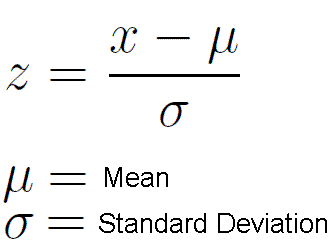

In [ ]:
scaler = StandardScaler()
df_temp = df_num_sc.copy()
df_num_sc[num_columns] = scaler.fit_transform(df_temp)

In [ ]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax = sns.boxplot(data=df_num_sc[num_columns] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

Super)

In [ ]:
df_train[num_columns] = df_num_sc

Repeat all steps for the test sample.

In [ ]:
df_num_sc_t = df_test[num_columns]
df_num_sc_t['px_height'] = np.sqrt(df_num_sc_t['px_height'])
df_num_sc_t['fc'] = np.sqrt(df_num_sc_t['fc'])
df_num_sc_t['sc_w'] = np.sqrt(df_num_sc_t['sc_w'])
df_temp = df_num_sc_t.copy()
df_num_sc_t[num_columns] = scaler.fit_transform(df_temp)
df_test[num_columns] = df_num_sc_t

In [ ]:
y_train = df_train['price_range']
X_train = df_train.drop('price_range', axis=1)
y_test = df_test['price_range']
X_test = df_test.drop('price_range', axis=1)

Now we can try linear models.

Logistic Regression.

In [ ]:
C_list = []
Score_list = []
for C_ in np.arange(0.1, 11, 0.2):
    clf = LogisticRegression(C=C_)
    aсс = cross_val_score(clf, X_train, y_train, cv=kf)
    Score_list.append(np.mean(aсс))
    C_list.append(C_)

In [ ]:
plt.plot(C_list, Score_list)
print(max(Score_list))

Take a look at what happens on the support vectors.

In [ ]:
C_list = []
Score_list = []
for C_ in np.arange(0.25, 10, 0.5):
    clf = SVC(C=C_)
    aсс = cross_val_score(clf, X_train, y_train, cv=kf)
    Score_list.append(np.mean(aсс))
    C_list.append(C_)

In [ ]:
plt.plot(C_list, Score_list)
print(max(Score_list))

On SVM, we did not get a high score. Before you abandon them, you should try changing the decision function. From the standard OneVsOne to OneVsRest. And also try polynomials.

In [ ]:
C_list = []
Score_list = []
for C_ in np.arange(0.1, 11, 0.2):
    clf = OneVsOneClassifier(LogisticRegression(C=C_))
    aсс = cross_val_score(clf, X_train, y_train, cv=kf)
    Score_list.append(np.mean(aсс))
    C_list.append(C_)

In [ ]:
plt.plot(C_list, Score_list)
print(max(Score_list))

Well, the decisive rule was really the decisive factor. The graph shows that the hyperparameter of regularization can be further increased. Create a GridSearch, and compare the results with the l1 regularizer.

In [ ]:
clf = OneVsOneClassifier(LogisticRegression())

parameters = {
    'estimator__C': np.arange(0.1, 21, 0.2),
    'estimator__penalty': ['l1','l2'],
    'estimator__solver': ['saga']
}

grid_logres = GridSearchCV(clf, param_grid=parameters, cv=kf)
grid_logres.fit(X_train, y_train)
print('best score: ', grid_logres.best_score_)
print('best param: ', grid_logres.best_params_)

Используем GridSearch на SVM.

In [ ]:
parameters = {
    'C': np.arange(0.1, 6, 0.2),
    'kernel': ['linear', 'rbf'],
    'gamma': ['auto', 1, 0.1, 0.01, 0.001],
    'decision_function_shape': ['ovo', 'ovr']
}
# Instead of the OneVsOneClassifier module, we use the SVC parameter - decision_function_shape

In [ ]:
clf = SVC()
grid_svc = GridSearchCV(clf, param_grid=parameters)
grid_svc.fit(X_train, y_train)
print('best score: ', grid_svc.best_score_)
print('best param: ', grid_svc.best_params_)

The best score was shown by the logistic regression model. Let's see what quality will be on the test sample.

In [ ]:
clf = grid_logres.best_estimator_
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

Let's see confusion matrix.

In [ ]:
prediction = clf.predict(X_test)
conf_mx = confusion_matrix(y_test, prediction)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

We focus on the mistakes.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums # let's move from absolute indicators to relative
np.fill_diagonal(norm_conf_mx, 0)

In [ ]:
sns.heatmap(data=norm_conf_mx, cbar=True, annot=True, square=True)

So, in our case, the rows are the actual classes, and the columns are the predicted classes. Most often, the classifier is mistaken in predicting the 1st and 2nd classes (Price_range 2, 3). The main conclusion that can be drawn is that the classifier can attribute the object in the worst case to a neighboring class. For example, an object of the 2nd class can be assigned to the 1st or 3rd, but it will never be assigned to the 1st class. This is important for our task because the target attribute is ranked.

In the next version we will implement the pipeline.

I'm just beginner in this business. I look forward tp your questions, comments and feedback. It's very important for me!